<a href="https://colab.research.google.com/github/Negfir/Deep-Learning-HWs/blob/main/HW1/DL_HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
import torch


In [2]:
from google.colab import drive
drive.mount('/content/gdrive' )

Mounted at /content/gdrive


In [3]:
%cd '/content/gdrive/My Drive/Dataset'


/content/gdrive/My Drive/Dataset


In [4]:
# Training Data
x_train = pd.read_csv('data/training_set.csv', header=None).values
y_train = pd.read_csv('data/training_labels_bin.csv', header=None).values
x_val = pd.read_csv('data/validation_set.csv', header=None).values
y_val = pd.read_csv('data/validation_labels_bin.csv', header=None).values
N = len(x_train)
x_train.shape

(8442, 354)

In [19]:
start = time.time()

torch.manual_seed(6)

num_feats = x_train.shape[1]
n_out = y_train.shape[1]

# hyperparameters (you may change these)
eta = 0.005 # intial learning rate
gamma = 0.1 # multiplier for the learning rate
stepsize = 200 # epochs before changing learning rate
threshold = 0.08 # stopping criterion
test_interval = 1 # number of epoch before validating
max_epoch = 30


# Define Architecture of NN
# [ ] Intialize your network weights and biases here

#Network size
inputSize = x_train.shape[1]
outputSize = 3
hidden_1_Size = 16
hidden_2_Size = 8

# Initializing weights and biases with random values
W1= np.random.rand(inputSize, hidden_1_Size)
W1 = 1 - (W1*2)
b1 = np.random.randn(hidden_1_Size)

W2= np.random.rand(hidden_1_Size, hidden_2_Size)
W2 = 1 - (W2*2)
b2 = np.random.randn(hidden_2_Size)

W3= np.random.rand(hidden_2_Size, outputSize)
W3 = 1 - (W3*2)
b3 = np.random.randn(outputSize)

def sigmoid(x):
    return 1/(1+np.exp(-x))

def sigmoid_der(x):
    return sigmoid(x) *(1-sigmoid (x))

#Predict and accuracy functions (Since the labels where 0 or 1, we added an extra function to test the model's accuracy and therefore added a treshold for assigning 0 or 1 to predictions. This part is extra and does not have any effect on the loss function and backpropagation)
def predict(x):
    z1_ = np.matmul(x,W1)+b1
    h1_ = sigmoid(z1_)
    z2_ = np.matmul( h1_, W2)+b2
    h2_ = sigmoid(z2_)
    z3_ = np.matmul(h2_, W3)+b3
    y_pred_ = sigmoid(z3_)
    # y_pred = np.where(y_pred > 0.5, 1, 0)
    return y_pred_

def accuracy(pred, y):
    acc=0
    for i,x in enumerate(pred):
      acc += np.sum(x == y[i])/float(len(y[i]))
    return acc/len(pred)


training_losses = []
val_loss=[]

for epoch in range(0, max_epoch):
    
    order = np.random.permutation(N) # shuffle data
    
    sse = 0
    sse_val = 0
    for n in range(0, N):
        idx = order[n]

        # get a sample (batch size=1)
        x_in = x_train[idx]
        y = y_train[idx]

        # [ ] do the forward pass here
        # hint: you need to save the output of each layer to calculate the gradients later
        z1 = np.matmul(x_in,W1)+b1
        h1 = sigmoid(z1)
        z2 = np.matmul( h1, W2)+b2
        h2 = sigmoid(z2)
        z3 = np.matmul(h2, W3)+b3
        y_pred = sigmoid(z3)
    
        # [ ] compute error and gradients here
        # hint: don't forget the chain rule

        #output layer gradients
        dsse_dy = np.sum(2*(y_pred - y))
        dy_dz3 = sigmoid_der(z3)
        dsse_dz3 = dsse_dy * dy_dz3
        dz3_dw3 = h2
        dsse_dw3 = np.dot(dsse_dz3.reshape(len(dsse_dz3),1),dz3_dw3.reshape(1,len(dz3_dw3)))
        dsse_db3 = np.dot(dsse_dy,dy_dz3)

        #hidden2 layer gradients
        dz3_dh2 = W3
        dsse_dh2 = np.dot(dz3_dh2,dsse_dz3)
        dh2_dz2 = sigmoid_der(z2)
        dsse_dz2 = dh2_dz2 * dsse_dh2
        dz2_dw2 = h1
        dsse_dw2 = np.dot(dsse_dz2.reshape(len(dsse_dz2),1),dz2_dw2.reshape(1,len(dz2_dw2)))
        dsse_db2 = dh2_dz2 * dsse_dh2

        #hidden1 layer gradients
        dz2_dh1 = W2
        dsse_dh1 = np.dot(dz2_dh1,dsse_dz2)
        dh1_dz1 = sigmoid_der(z1)
        dsse_dz1 = dh1_dz1 * dsse_dh1
        dz1_dw1 = x_in
        dsse_dw1 = np.dot(dsse_dz1.reshape(len(dsse_dz1),1),dz1_dw1.reshape(1,len(dz1_dw1)))
        dsse_db1 = dh1_dz1 * dsse_dh1



        # [ ] update weights and biases here
        # update weights and biases in output layer 
        W1 -= eta * dsse_dw1.T
        b1 -= eta * dsse_db1

        W2 -= eta * dsse_dw2.T
        b2 -= eta * dsse_db2

        W3 -= eta * dsse_dw3.T
        b3 -= eta * dsse_db3

    
        sse += np.sum((predict(x_in) - y)**2) #squared_error
    training_losses.append(sse/N)
    print(len(y_train))

    #Accuracy
    acc = accuracy(predict(x_train),y_train)
    print(f"Accuracy of Trial {epoch}: {acc} ------ Loss= {sse/len(y_train)}")
    

    if epoch % test_interval == 0: 
        # [ ] test on validation set here
        acc_val = accuracy(predict(x_val),y_val)
        sse_val_vec = np.sum((predict(x_val) - y_val)**2,axis =1)
        # print(sse_val_vec)
        sse_val = np.sum(sse_val_vec)/len(y_val) #squared_error
        print(f"Accuracy of Test {epoch}: {acc_val} ------ Loss= {sse_val}")
        val_loss.append(sse_val)
    
        # if termination condition is satisfied, exit
        if (sse_val) < threshold:
            break


    if epoch % stepsize == 0 and epoch != 0:
        eta = eta*gamma
        print('Changed learning rate to lr=' + str(eta))

8442
Accuracy of Trial 0: 0.0 ------ Loss= 0.7776811048168446
Accuracy of Test 0: 0.0 ------ Loss= 0.7203594633947656
8442
Accuracy of Trial 1: 0.0 ------ Loss= 0.7092481689795884
Accuracy of Test 1: 0.0 ------ Loss= 0.5771809924807136
8442
Accuracy of Trial 2: 0.0 ------ Loss= 0.6598735101952091
Accuracy of Test 2: 0.0 ------ Loss= 0.530937367852858
8442
Accuracy of Trial 3: 0.0 ------ Loss= 0.6413130034503228
Accuracy of Test 3: 0.0 ------ Loss= 0.49768741974900993
8442
Accuracy of Trial 4: 0.0 ------ Loss= 0.6266419377964807
Accuracy of Test 4: 0.0 ------ Loss= 0.4846704205577033
8442
Accuracy of Trial 5: 0.0 ------ Loss= 0.6113703986538083
Accuracy of Test 5: 0.0 ------ Loss= 0.4547494428377915
8442
Accuracy of Trial 6: 0.0 ------ Loss= 0.5976925139162871
Accuracy of Test 6: 0.0 ------ Loss= 0.41789898122211727
8442
Accuracy of Trial 7: 0.0 ------ Loss= 0.5865491312310535
Accuracy of Test 7: 0.0 ------ Loss= 0.4171242941008075
8442
Accuracy of Trial 8: 0.0 ------ Loss= 0.5772949848

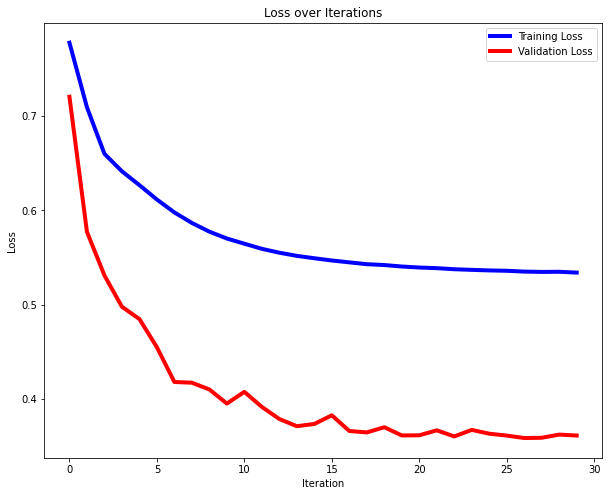

In [20]:
plt.figure(figsize=(10,8))
plt.plot(training_losses[0:100], lw=4, color='blue', label='Training Loss')
plt.plot(val_loss[0:100], lw=4, color='red', label='Validation Loss')

plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss over Iterations')
plt.legend()